Enter sequence encoding:10


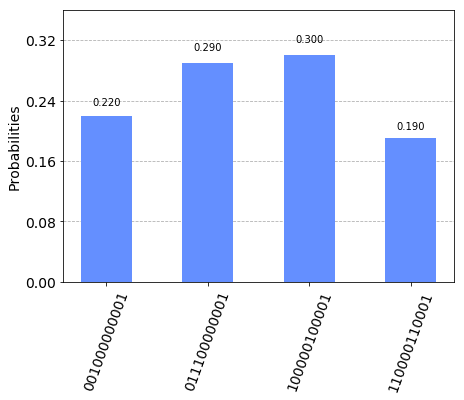

In [4]:
# (C) Copyright Renata Wong 2020.

from qiskit import *

# sequence length = 2 only!
sequence = list(input('Enter sequence encoding:' ))
length = len(sequence)

# quantum register holding the sequence encoding
s = QuantumRegister(length,'s')
# quantum register holding the x coordinates
x = QuantumRegister(length**2, 'x')
# quantum register holding the y coordinates
y = QuantumRegister(length**2, 'y')
# quantum register holding the controls w0, w1
w = QuantumRegister(2*(length-1), 'w')
# register holding the binary 1
a = QuantumRegister(length,'a')
# register holding the two's complement of 1
t = QuantumRegister(length,'t')
# register holding the carry bit for ripple-carry-adder
c = QuantumRegister(1,'c')
# classical register
out = ClassicalRegister(12,'o')
# quantum circuit consisting of all quantum and classical registers
qc = QuantumCircuit(s,x,y,w,a,t,c,out)

# initialisation of sequence encoding depending on the input
for k, i in zip(sequence, range(length)):
    if k is '1':
        qc.x(s[i])

# encoding binary 1
qc.x(a[length-1])
# encoding the two's complement of 1
qc.x(t[0:length])

# setting the state into superposition
qc.h(w[0:(length-1)*2])

anc = QuantumRegister(3,'anc') # three ancilla qubits needed for riple-carry adder controled by two qubits
qc.add_register(anc)


# subcircuit defined for the controlled-controlled ripple-carry adder for 2 bits
sq = QuantumRegister(3+2+1+2*length)
sc = QuantumCircuit(sq)

sc.ccx(sq[0],sq[1],sq[2])
sc.ccx(sq[2],sq[7],sq[3])
sc.cx(sq[3],sq[9])
sc.cx(sq[3],sq[5])
sc.ccx(sq[2],sq[7],sq[3])
sc.ccx(sq[2],sq[6],sq[3])
sc.ccx(sq[3],sq[8],sq[4])
sc.cx(sq[4],sq[5])
sc.ccx(sq[3],sq[8],sq[4])
sc.ccx(sq[2],sq[6],sq[3])
sc.ccx(sq[2],sq[5],sq[3])
sc.ccx(sq[3],sq[9],sq[4])
sc.cx(sq[4],sq[7])
sc.ccx(sq[3],sq[9],sq[4])
sc.ccx(sq[2],sq[5],sq[3])
sc.cx(sq[2],sq[9])
sc.ccx(sq[2],sq[5],sq[3])
sc.cx(sq[3],sq[9])
sc.ccx(sq[2],sq[5],sq[3])
sc.ccx(sq[2],sq[5],sq[3])
sc.ccx(sq[3],sq[9],sq[4])
sc.cx(sq[4],sq[7])
sc.ccx(sq[3],sq[9],sq[4])
sc.ccx(sq[2],sq[5],sq[3])
sc.cx(sq[2],sq[9])
sc.ccx(sq[2],sq[6],sq[3])
sc.ccx(sq[3],sq[8],sq[4])
sc.cx(sq[4],sq[5])
sc.ccx(sq[3],sq[8],sq[4])
sc.ccx(sq[2],sq[6],sq[3])
sc.ccx(sq[2],sq[7],sq[3])
sc.cx(sq[3],sq[5])
sc.ccx(sq[2],sq[7],sq[3])
sc.ccx(sq[2],sq[7],sq[3])
sc.cx(sq[3],sq[9])
sc.ccx(sq[2],sq[7],sq[3])
sc.ccx(sq[2],sq[6],sq[3])
sc.cx(sq[3],sq[8])
sc.ccx(sq[2],sq[6],sq[3])
sc.ccx(sq[0],sq[1],sq[2])

subinst = sc.to_instruction()

  
# global variable used in Algorithm 1 to navigate in the indices of vector w
b = 0

# Algorithm 1
for d in range (2, length+1):
    for q in range (0, length):
        qc.cx(x[(d-2)*length+q],x[(d-1)*length+q])
        qc.cx(y[(d-2)*length+q],y[(d-1)*length+q])
    
    # calculating the western neighbour of site d-1 (w=11)
    qc.append(subinst,[w[b],w[b+1],anc[0],anc[1],anc[2],c[0],t[0],t[1],x[(d-1)*length],x[d*length-1]])   
    qc.x(w[b])
    # calculating the eastern neighbour of site d-1 (w=01)
    qc.append(subinst,[w[b],w[b+1],anc[0],anc[1],anc[2],c[0],a[0],a[1],x[(d-1)*length],x[d*length-1]])
    qc.x(w[b+1])
    # calculating the northern neighbour of site d-1 (w=00)
    qc.append(subinst,[w[b],w[b+1],anc[0],anc[1],anc[2],c[0],a[0],a[1],y[(d-1)*length],y[d*length-1]])
    qc.x(w[b])
    # calculating the southern neighbour of site d-1 (w=10)
    qc.append(subinst,[w[b],w[b+1],anc[0],anc[1],anc[2],c[0],t[0],t[1],y[(d-1)*length],y[d*length-1]])
    qc.x(w[b+1])
    b = b+2
        

qc.measure([s[0],s[1],x[0],x[1],x[2],x[3],y[0],y[1],y[2],y[3],w[0],w[1],],out)
simulator = Aer.get_backend('qasm_simulator')
result = execute(qc,backend = simulator, shots = 100).result()
counts = result.get_counts()
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)